## How Diverse is Our Synthesized Data?

In [57]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

MAX_NUM = 500

In [ ]:
## Load data
with open('mobile_task_driven.json', 'r') as file:
    mobile_task_driven_data = json.load(file)
with open('mobile_self_instruct.json', 'r') as file:
    mobile_self_instruct_data = json.load(file)
with open('mobile_ours.json', 'r') as file:
    mobile_ours_data = json.load(file)
with open('mobile_human.json', 'r') as file:
    mobile_human_data = json.load(file)


with open('web_task_driven.json', 'r') as file:
    web_task_driven_data = json.load(file)
with open('web_self_instruct.json', 'r') as file:
    web_self_instruct_data = json.load(file)
with open('web_ours.json', 'r') as file:
    web_ours_data = json.load(file)

web_ours_data[0]

{'episode_id': '492d46b3-34f3-47bb-a796-995bc2066d0c',
 'web_name': 'gitlab',
 'instruction': "Review all tasks in your To-Do List and mark the task 'feat: add WCAG levels' for the project 'The A11Y Project' as done.",
 'steps': [{'reason_action': "Let's think step-by-step. The objective is to review all tasks in the To-Do List and mark the task 'feat: add WCAG levels' for the project 'The A11Y Project' as done. \n\n1. The To-Do List can be accessed by clicking the 'To-Do List' link.\n2. Once in the To-Do List, look for the task 'feat: add WCAG levels' under 'The A11Y Project'.\n3. Mark the task as done.\n\nFirst, I need to navigate to the To-Do List. In summary, the next action I will perform is ```click [471]```."},
  {'reason_action': 'Let\'s think step-by-step. The current page shows the "To-Do List" on GitLab, but it indicates that there are no tasks in the "To Do" section and 7 tasks in the "Done" section. To find the task \'feat: add WCAG levels\' for the project \'The A11Y Proj

In [59]:
## Extract instructions
mobile_task_driven = [d['instruction'] for d in mobile_task_driven_data]
mobile_self_instruct = [d['instruction'] for d in mobile_self_instruct_data]
mobile_ours = [d['instruction'] for d in mobile_ours_data]
mobile_human = [d['instruction'] for d in mobile_human_data]

web_task_driven = [d['instruction'] for d in web_task_driven_data]
web_self_instruct = [d['instruction'] for d in web_self_instruct_data]
web_ours = [d['instruction'] for d in web_ours_data]

In [ ]:
## Extract trajectories
mobile_task_driven_traj = []
for episode in mobile_task_driven_data:
    if 'steps' in episode:
        for step in episode['steps']:
            mobile_task_driven_traj.append(step['reason'])

mobile_self_instruct_traj = []
for episode in mobile_self_instruct_data:
    if 'steps' in episode:
        for step in episode['steps']:
            mobile_self_instruct_traj.append(step['reason'])

mobile_ours_traj = []
for episode in mobile_ours_data:
    if 'steps' in episode:
        for step in episode['steps']:
            mobile_ours_traj.append(step['reason'])

mobile_human_traj = []
for episode in mobile_human_data:
    if 'steps' in episode:
        for step in episode['steps']:
            mobile_human_traj.append(step['reason'])

web_task_driven_traj = []
for episode in web_task_driven_data:
    if 'steps' in episode:
        for step in episode['steps']:
            web_task_driven_traj.append(step['reason_action'])

web_self_instruct_traj = []
for episode in web_self_instruct_data:
    if 'steps' in episode:
        for step in episode['steps']:
            web_self_instruct_traj.append(step['reason_action'])

web_ours_traj = []
for episode in web_ours_data:
    if 'steps' in episode:
        for step in episode['steps']:
            web_ours_traj.append(step['reason_action'])

print("Average number of steps in a task:")
print(f"Mobile Task Driven: {len(mobile_task_driven_traj) / 500:.2f}")
print(f"Mobile Self Instruct: {len(mobile_self_instruct_traj) / 500:.2f}")
print(f"Mobile Ours: {len(mobile_ours_traj) / 500:.2f}")
print(f"Mobile Human: {len(mobile_human_traj) / 500:.2f}")

print(f"Web Task Driven: {len(web_task_driven_traj) / 500:.2f}")
print(f"Web Self Instruct: {len(web_self_instruct_traj) / 500:.2f}")
print(f"Web Ours: {len(web_ours_traj) / 500:.2f}")

mobile_task_driven_traj, mobile_self_instruct_traj, mobile_ours_traj, mobile_human_traj, web_task_driven_traj, web_self_instruct_traj, web_ours_traj = [x[:MAX_NUM] for x in [mobile_task_driven_traj, mobile_self_instruct_traj, mobile_ours_traj, mobile_human_traj, web_task_driven_traj, web_self_instruct_traj, web_ours_traj]]

Average number of steps in a task:
Mobile Task Driven: 5.64
Mobile Self Instruct: 3.43
Mobile Ours: 5.60
Mobile Human: 5.31
Web Task Driven: 8.74
Web Self Instruct: 7.37
Web Ours: 4.46


In [ ]:
## Compute diversity scores using Sentence-BERT and cosine distance

def diversity_score(sentences, model):
    # Encode sentences using a semantic model like Sentence-BERT
    embeddings = model.encode(sentences)
    dist_matrix = cosine_distances(embeddings)

    # Extract upper-triangular part (excluding diagonal)
    upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
    return np.mean(upper_tri)

# Load a Sentence-BERT model (this one is small and fast)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Compute diversity scores for Instructions
instruction_scores = {
    "mobile_task_driven": diversity_score(mobile_task_driven, model),
    "mobile_self_instruct": diversity_score(mobile_self_instruct, model),
    "mobile_ours": diversity_score(mobile_ours, model),
    "mobile_human": diversity_score(mobile_human, model),
    "web_task_driven": diversity_score(web_task_driven, model),
    "web_self_instruct": diversity_score(web_self_instruct, model),
    "web_ours": diversity_score(web_ours, model)
}

# Compute diversity scores for Trajectories
trajectory_scores = {
    "mobile_task_driven": diversity_score(mobile_task_driven_traj, model),
    "mobile_self_instruct": diversity_score(mobile_self_instruct_traj, model),
    "mobile_ours": diversity_score(mobile_ours_traj, model),
    "mobile_human": diversity_score(mobile_human_traj, model),
    "web_task_driven": diversity_score(web_task_driven_traj, model),
    "web_self_instruct": diversity_score(web_self_instruct_traj, model),
    "web_ours": diversity_score(web_ours_traj, model)
}

print("Instruction diversity scores: ", instruction_scores)
print("Trajectory diversity scores: ", trajectory_scores)

Instruction diversity scores:  {'mobile_task_driven': 0.768097, 'mobile_self_instruct': 0.749533, 'mobile_ours': 0.8367332, 'mobile_human': 0.86828065, 'web_task_driven': 0.79470116, 'web_self_instruct': 0.7868804, 'web_ours': 0.8667911}
Trajectory diversity scores:  {'mobile_task_driven': 0.7846318, 'mobile_self_instruct': 0.7574606, 'mobile_ours': 0.8185811, 'mobile_human': 0.7244226, 'web_task_driven': 0.7685344, 'web_self_instruct': 0.79188716, 'web_ours': 0.80232036}


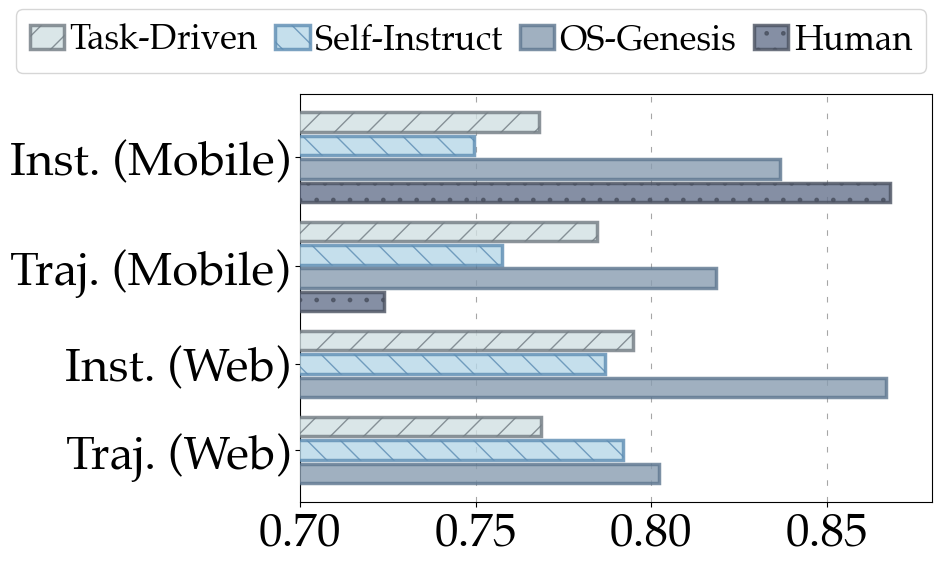

In [ ]:
## Plot the diversity scores

metrics = ['Inst. (Mobile)', 'Traj. (Mobile)', 'Inst. (Web)', 'Traj. (Web)']
methods = ['Task-Driven', 'Self-Instruct', 'OS-Genesis']
data = np.array([
    [instruction_scores["mobile_task_driven"], trajectory_scores["mobile_task_driven"], instruction_scores["web_task_driven"], trajectory_scores["web_task_driven"]],  # Task-Driven
    [instruction_scores["mobile_self_instruct"],trajectory_scores["mobile_self_instruct"], instruction_scores["web_self_instruct"], trajectory_scores["web_self_instruct"]],  # Self-Instruct
    [instruction_scores["mobile_ours"], trajectory_scores["mobile_ours"], instruction_scores["web_ours"], trajectory_scores["web_ours"]],  # OS-Genesis
])
data_1 = data[:, :2]
data_2 = data[:, 2:]

show_values = False

# Instead of x for categories, we'll use y for category positioning
y_1 = np.array([0, 1.4])
y_2 = np.array([2.65, 3.75])
bar_height = 0.25
spacing = 0.05
edge_width = 2.5

colors = ['#D1E0E3', '#B7D7E8', '#899DB1']
edge_colors = ['#707A81', '#5B8BB2', '#5D768F']
hatch_patterns = ['/', '\\', '']

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.size"] = 26

fig, ax = plt.subplots(figsize=(10, 6.5))

# For a horizontal bar chart, it's common to use vertical gridlines
ax.xaxis.grid(True, linestyle=(0, (5, 10)), which='both', color='gray', alpha=0.7, zorder=0)

offsets_1 = [(-1.5*(bar_height+spacing)), (-0.5*(bar_height+spacing)), (0.5*(bar_height+spacing))]
offsets_2 = [(-1*(bar_height+spacing)), 0, (1*(bar_height+spacing))]
rects = []

for i, (method, color, edge_color, hatch) in enumerate(zip(methods, colors, edge_colors, hatch_patterns)):
    rect = ax.barh(
        y_1 + offsets_1[i], data_1[i],
        height=bar_height, label=method,
        color=color, edgecolor=edge_color, linewidth=edge_width, zorder=3,
        hatch=hatch, alpha=0.8
    )
    rects.append(rect)


    rect = ax.barh(
        y_2 + offsets_2[i], data_2[i],
        height=bar_height, # label=method,
        color=color, edgecolor=edge_color, linewidth=edge_width, zorder=3,
        hatch=hatch, alpha=0.8
    )
    rects.append(rect)
ax.invert_yaxis()


# Now add the Human method for the first two metrics only
human_method = 'Human'
human_data = [0.868, 0.724]
human_color = '#67738D'
human_edge_color = '#4A5160'
human_hatch = '.'

human_rect = ax.barh(
    y_1 + 1.5*(bar_height+spacing),  # Only plot for the first two metrics
    human_data,
    height=bar_height, label=human_method,
    color=human_color, edgecolor=human_edge_color,
    linewidth=edge_width, zorder=3, hatch=human_hatch,
    alpha=0.8
)
rects.append(human_rect)


# Set the x-limit (horizontal axis) to show the data range
ax.set_xlim(0.7, 0.88)
ax.set_yticks(np.concatenate((y_1, y_2)))
ax.set_yticklabels(metrics, fontsize=34)
ax.tick_params(axis='x', labelsize=34)

ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.27, 1.25),
    ncol=4,
    fontsize=25,
    handletextpad=0.15,
    handlelength=1,
    columnspacing=0.5
)

if show_values:
    def autolabel(rects, color):
        for rect in rects:
            width = rect.get_width()
            # Place the label at the end of the bar
            ax.annotate(f'{width:.2f}',
                        xy=(width, rect.get_y() + rect.get_height() / 2),
                        xytext=(3, 0),  # Offset text slightly
                        textcoords="offset points",
                        ha='left', va='center', color=color, fontsize=22)
    for r, c in zip(rects, edge_colors):
        autolabel(r, c)

fig.tight_layout()
plt.savefig('diversity_comparison.pdf', bbox_inches='tight')
plt.show()

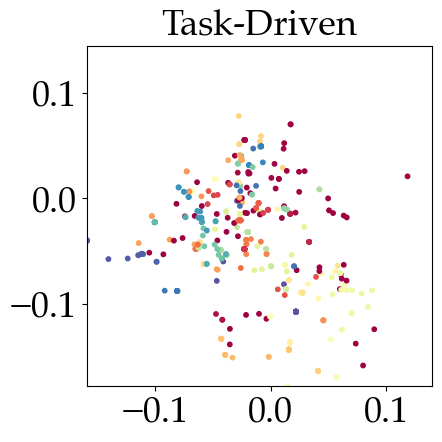

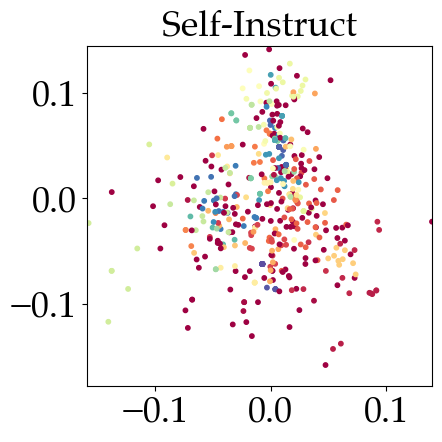

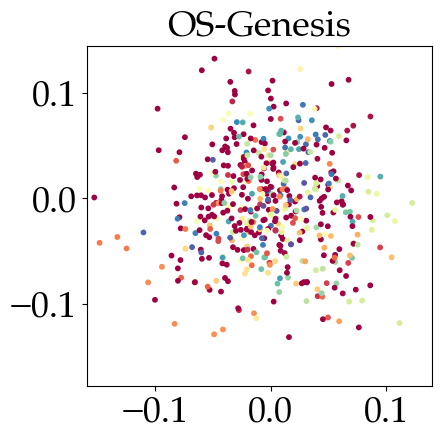

In [ ]:
## Visualize the embeddings

# Visualization function
def visualize_embeddings(embeddings, labels, title, xlim, ylim, filename):
    plt.figure(figsize=(5, 5))  # Adjust figsize as needed
    scatter = plt.scatter(
        embeddings[:, 0], embeddings[:, 1], c=labels, cmap="Spectral", s=10
    )
    plt.title(title, fontsize=26)
    plt.axis("on")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams["font.size"] = 26
    
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Load Sentence-BERT model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Compute diversity scores and embeddings
div_score_1, embeddings_1 = diversity_score(mobile_task_driven, model)
div_score_2, embeddings_2 = diversity_score(mobile_self_instruct, model)
div_score_3, embeddings_3 = diversity_score(mobile_ours, model)

# Combine all embeddings to find global limits
all_embeddings = np.vstack([embeddings_1, embeddings_2, embeddings_3])
x_min, x_max = np.min(all_embeddings[:, 0]), np.max(all_embeddings[:, 0])
y_min, y_max = np.min(all_embeddings[:, 1]), np.max(all_embeddings[:, 1])
xlim = (x_min, x_max)
ylim = (y_min, y_max)

# Apply HDBSCAN clustering
clusterer_1 = HDBSCAN(min_cluster_size=2).fit(embeddings_1)
clusterer_2 = HDBSCAN(min_cluster_size=2).fit(embeddings_2)
clusterer_3 = HDBSCAN(min_cluster_size=2).fit(embeddings_3)

# Visualize each embedding set separately
visualize_embeddings(
    embeddings_1, clusterer_1.labels_, "Task-Driven", xlim, ylim, 'diversity_visualization_1.pdf'
)
visualize_embeddings(
    embeddings_2, clusterer_2.labels_, "Self-Instruct", xlim, ylim, 'diversity_visualization_2.pdf'
)
visualize_embeddings(
    embeddings_3, clusterer_3.labels_, "OS-Genesis", xlim, ylim, 'diversity_visualization_3.pdf'
)

In [28]:
## Calculate average word count in instructions

# Function to calculate average number of words in a list of strings
def average_word_count(data_list):
    total_words = sum(len(item.split()) for item in data_list)
    return total_words / len(data_list) if data_list else 0

# Calculating averages for each list
avg_mobile_task_driven = average_word_count(mobile_task_driven)
avg_mobile_self_instruct = average_word_count(mobile_self_instruct)
avg_mobile_ours = average_word_count(mobile_ours)
avg_mobile_human = average_word_count(mobile_human)

avg_web_task_driven = average_word_count(web_task_driven)
avg_web_self_instruct = average_word_count(web_self_instruct)
avg_web_ours = average_word_count(web_ours)

# Displaying the results
print("Average word count in instructions:")
print(f"Mobile Task Driven: {avg_mobile_task_driven:.2f}:")
print(f"Mobile Self Instruct: {avg_mobile_self_instruct:.2f}")
print(f"Mobile Ours: {avg_mobile_ours:.2f}")
print(f"Mobile Human: {avg_mobile_human:.2f}")
print(f"Web Task Driven: {avg_web_task_driven:.2f}")
print(f"Web Self Instruct: {avg_web_self_instruct:.2f}")
print(f"Web Ours: {avg_web_ours:.2f}")

Average word count in instructions:
Mobile Task Driven: 9.64:
Mobile Self Instruct: 9.84
Mobile Ours: 18.01
Mobile Human: 18.71
Web Task Driven: 11.79
Web Self Instruct: 8.45
Web Ours: 19.68
